In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import f1_score, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt

In [2]:
train_df = pd.read_csv("./Saved_Predict_and_Proba/HateVal/prob_train_hateval.csv").dropna()
val_df = pd.read_csv("./Saved_Predict_and_Proba/HateVal/prob_val_hateval.csv").dropna()
test_df = pd.read_csv("./Saved_Predict_and_Proba/HateVal/prob_test_hateval.csv").dropna()

probas_train, labels_train = train_df.drop(columns=["Unnamed: 0", "HS"]), train_df["HS"]
probas_val, labels_val = val_df.drop(columns=["Unnamed: 0", "HS"]), val_df["HS"]
probas_test, labels_test = test_df.drop(columns=["Unnamed: 0", "HS"]), test_df["HS"]

In [108]:
def filter_df_train_test(train_df, test_df, name, filter_first=True):
    train = train_df.filter(regex=name, axis=1)
    test = test_df.filter(regex=name, axis=1)
    return train.to_numpy(), test.to_numpy(), train.columns

def filter_collinearity(X_train, X_test):
    X_train = X_train[:, ::2]
    X_test = X_test[:, ::2]
    return X_train, X_test
stacking = LogisticRegression()

def generate_confusion_matrix(stacking, X_test, labels_test, name):
    disp = plot_confusion_matrix(stacking, X_test, 
                             labels_test, cmap=plt.cm.Blues, display_labels=['Non-hateful', 'hateful'])
    disp.ax_.set_title(name)
    plt.tight_layout()
    plt.savefig('confusion_matrix_' + name+'.pdf', dpi=300)
    
def create_coefficient_plot(coefs, names, group, savename):
    log_odds = np.exp(coefs.T)
    log_odds = pd.DataFrame(log_odds,names,['Coef']).sort_values(by='Coef', ascending=False)
    log_odds.round(3)
    log_odds.plot.bar()
    plt.ylabel('LR Coefficients')
    plt.xlabel(group)
    plt.tight_layout()
    plt.savefig(savename+'.pdf', dpi=300)
    
def organize_names_df(names):
    names_coeffs = names[::2]
    names_coeffs = [name.replace("-0", "") for name in names_coeffs]
    names_coeffs = [name.replace("-CV", "-TF") for name in names_coeffs]
    return names_coeffs

## Stacking group A - Varying Classification methods

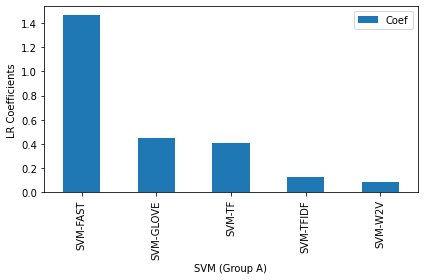

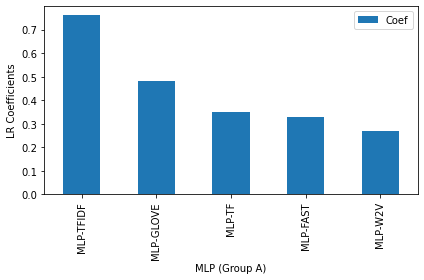

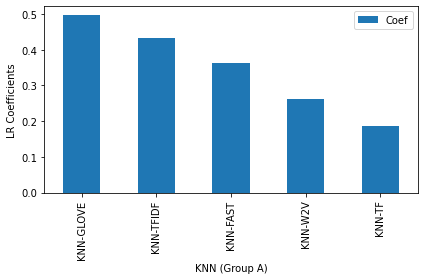

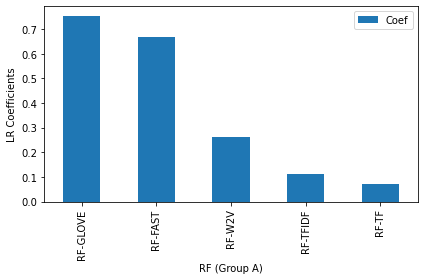

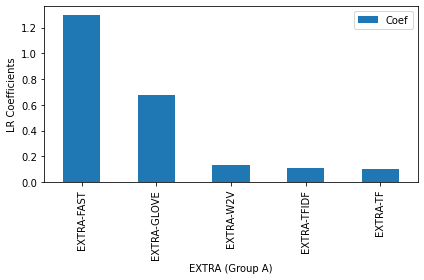

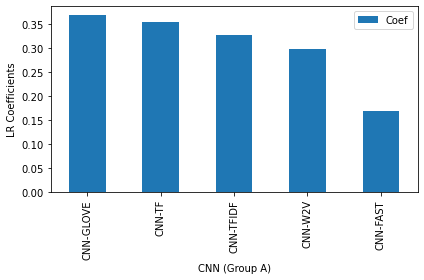

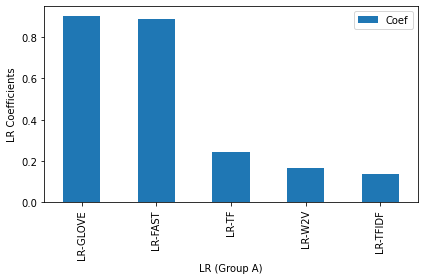

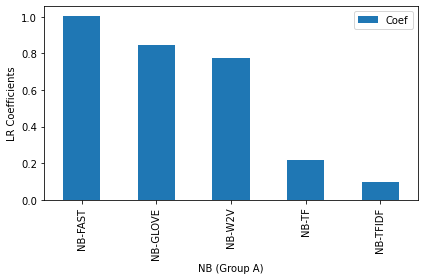

In [116]:
algorithms_list = ['SVM', 'MLP', 'KNN', 'RF', 'EXTRA', 'CNN', 'LR', 'NB']
stacking = LogisticRegression(class_weight='balanced')

results_A = np.zeros(len(algorithms_list))

for idx_alg, algorithm in enumerate(algorithms_list):
    X_val, X_test, cols = filter_df_train_test(probas_val, probas_test, algorithm)
    X_val, X_test = filter_collinearity(X_val, X_test)
    stacking.fit(X_val, labels_val)
    y_pred = stacking.predict(X_test)
    score = f1_score(labels_test, y_pred)
    results_A[idx_alg] = score
    name = "Confusion Matrix "+algorithm+" (Group A)"
    
    feature_names = organize_names_df(cols)
    create_coefficient_plot(stacking.coef_, feature_names, algorithm+" (Group A)", "Coefficients Group A - "+algorithm)
#    generate_confusion_matrix(stacking, X_test, labels_test, name)

In [5]:
results_A

array([0.61454545, 0.62395242, 0.56133942, 0.58724249, 0.592245  ,
       0.59079284, 0.60772922, 0.60150376])

# Stacking group B - Varying Feature Representation methods

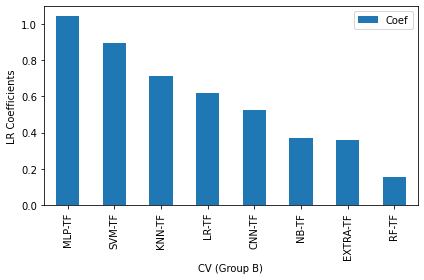

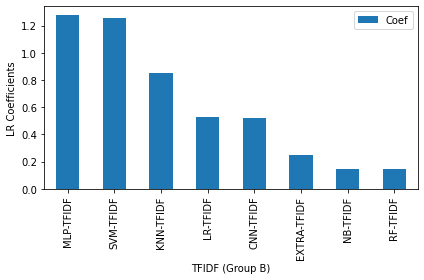

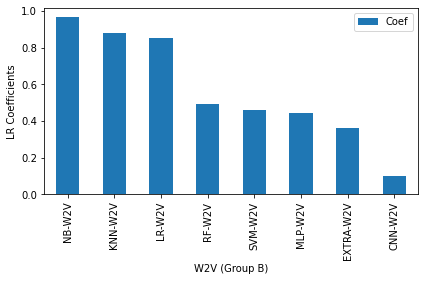

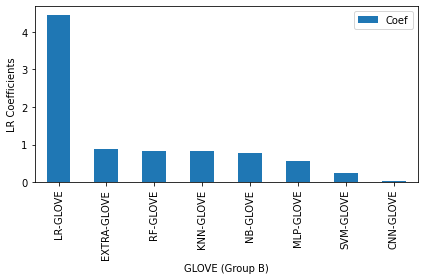

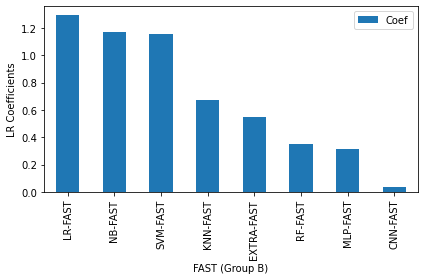

In [117]:
fe_list = ['CV', 'TFIDF', 'W2V', 'GLOVE', 'FAST']
stacking = LogisticRegression(class_weight='balanced')

results_B = np.zeros(len(fe_list))
for idx_alg, fe in enumerate(fe_list):
    X_val, X_test, cols = filter_df_train_test(probas_val, probas_test, fe)
    X_val, X_test = filter_collinearity(X_val, X_test)
    stacking.fit(X_val, labels_val)
    y_pred = stacking.predict(X_test)
    results_B[idx_alg] = f1_score(labels_test, y_pred)
    # hack for mismatched name.
    if fe == 'CV':
        name = "Confusion Matrix TF (Group B)"
    else:
        name = "Confusion Matrix "+fe+" (Group B)"
    feature_names = organize_names_df(cols)
    create_coefficient_plot(stacking.coef_, feature_names, fe+" (Group B)", "Coefficients Group B - "+fe)

#     generate_confusion_matrix(stacking, X_test, labels_test, name)


In [7]:
results_B

array([0.59364133, 0.59231905, 0.62061463, 0.60233593, 0.61457233])

# Stacking group C -  ALL techniques

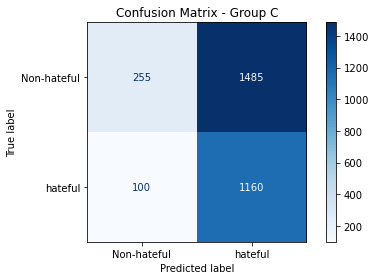

In [8]:
results_C = 0
stacking_C = LogisticRegression()
X_val, X_test = filter_collinearity(probas_val.to_numpy(), probas_test.to_numpy())
stacking_C.fit(X_val, labels_val)
y_pred = stacking_C.predict(X_test)
results_C = f1_score(labels_test, y_pred)
disp = plot_confusion_matrix(stacking_C, X_test, 
                             labels_test, cmap=plt.cm.Blues, display_labels=['Non-hateful', 'hateful'])
disp.ax_.set_title("Confusion Matrix - Group C")
plt.tight_layout()
plt.savefig('confusion_matrix_GROUP_C.pdf', dpi=300)

In [9]:
print(results_C)

0.5941101152368758


In [11]:
results_C

0.5941101152368758

In [33]:
stacking_C.coef_

array([[-0.36354235,  0.97020815, -1.21310611, -1.13737858,  0.81299152,
        -0.13231043, -0.60686795,  0.27319889,  0.89984741,  0.40810056,
        -1.13374226, -0.96704131, -0.34377343,  0.47070996,  0.03418888,
        -0.39636662, -0.95922167, -0.01415102, -0.17299496,  0.20397408,
        -0.17782258,  0.37921519, -0.51503929,  0.06735434, -0.29305907,
        -0.42190197, -0.3272335 , -0.76495109,  0.29792155,  0.80190736,
        -0.33162791, -0.39362237,  0.19462249, -0.23291655, -0.17179063,
        -0.17436087,  0.21911028, -0.43469222, -0.40046354, -0.7959246 ]])

# Stacking group D - Proposed Selection scheme

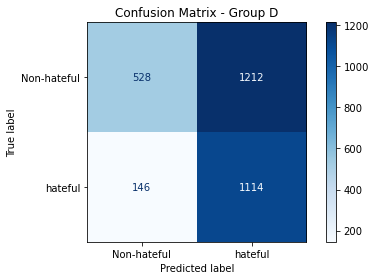

In [13]:
models_D = ['MLP-GLOVE','MLP-FAST','SVM-CV','MLP-W2V','SVM-W2V','LR-GLOVE','RF-W2V','CNN-W2V']
names = 'MLP-GLOVE|MLP-FAST|SVM-CV|MLP-W2V|SVM-W2V|LR-GLOVE|RF-W2V|CNN-W2V'
X_val, X_test, cols = filter_df_train_test(probas_val, probas_test, names)
X_val, X_test = filter_collinearity(X_val, X_test)
stacking_D = LogisticRegression()

stacking_D.fit(X_val, labels_val)
y_pred = stacking_D.predict(X_test)
results_D = f1_score(labels_test, y_pred)
disp=plot_confusion_matrix(stacking_D, X_test, labels_test, cmap=plt.cm.Blues,
                           display_labels=['Non-hateful', 'hateful'])
disp.ax_.set_title("Confusion Matrix - Group D")
plt.tight_layout()
plt.savefig('confusion_matrix_GroupD.pdf', dpi=300)

In [18]:
print(results_D)

0.6213050752928053


In [32]:
stacking_D.coef_

array([[-1.6937236 , -0.93342326,  0.31352523, -1.09842958, -0.79498981,
        -0.19138758, -0.04566218, -1.67363917]])

## Analyzing coefficients

In [25]:
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax

## Coefficients for group D

In [71]:
models_D = ['MLP-GLOVE','MLP-FAST','SVM-TF','MLP-W2V','SVM-W2V','LR-GLOVE','RF-W2V','CNN-W2V']
odds_D = np.exp(stacking_D.coef_.T)
odds_D = pd.DataFrame(odds_D,models_D,['Coef']).sort_values(by='Coef', ascending=False)
odds_D.round(3)

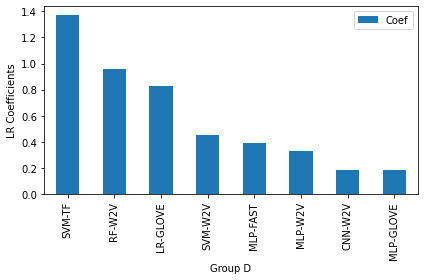

In [89]:
create_coefficient_plot(stacking_D.coef_, models_D, 'Group D', 'testi')

## Coefficients for group C

In [106]:
names_coeffs = organize_names_df(probas_val.columns)

In [107]:
names_coeffs

['SVM-TF',
 'SVM-TFIDF',
 'SVM-W2V',
 'SVM-GLOVE',
 'SVM-FAST',
 'LR-TF',
 'LR-TFIDF',
 'LR-W2V',
 'LR-GLOVE',
 'LR-FAST',
 'RF-TF',
 'RF-TFIDF',
 'RF-W2V',
 'RF-GLOVE',
 'RF-FAST',
 'NB-TF',
 'NB-TFIDF',
 'NB-W2V',
 'NB-GLOVE',
 'NB-FAST',
 'MLP-TF',
 'MLP-TFIDF',
 'MLP-W2V',
 'MLP-GLOVE',
 'MLP-FAST',
 'EXTRA-TF',
 'EXTRA-TFIDF',
 'EXTRA-W2V',
 'EXTRA-GLOVE',
 'EXTRA-FAST',
 'KNN-TF',
 'KNN-TFIDF',
 'KNN-W2V',
 'KNN-GLOVE',
 'KNN-FAST',
 'CNN-TF',
 'CNN-TFIDF',
 'CNN-W2V',
 'CNN-GLOVE',
 'CNN-FAST']

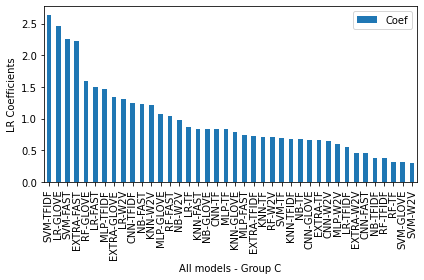

In [90]:
create_coefficient_plot(stacking_C.coef_, names_coeffs, 'All models - Group C', 'testi')

“For every one-unit increase in [X variable], the odds that the observation is in (y class) are [coefficient] times as large as the odds that the observation is not in (y class) when all other variables are held constant.”


So, as variable RM (again, average number of rooms) increases by one unit, the odds that the houses represented in the observation are in the target class (“1”) are over 6x as large as the odds that they won’t be in the target class. On the other hand, as concentration of nitric oxide increases by one unit, the odds that the houses are in the target class are only ~0.15. For odds less than 1 (our negative coefficients), we can take 1/odds to make even better sense of them. So as nitric oxide increases by 1, the odds that the house is NOT in the target class are 1/0.15 or 6.66x (ominous!) as likely as the odds that it IS in the target class.

## Summarizing results

In [16]:
all_stacking_names = ['Logistic Regression']
algorithms_list_A = [alg + ' (Group A)' for alg in algorithms_list]
group_A_df = pd.DataFrame(results_A, columns=all_stacking_names, index=algorithms_list_A)

fe_list_B = [fe + ' (Group B)' for fe in fe_list]
group_B_df = pd.DataFrame(results_B, columns=all_stacking_names, index=fe_list_B)

group_C_df = pd.DataFrame(results_C.reshape(1, 1), columns=all_stacking_names, index=['Group C'])
group_D_df = pd.DataFrame(results_D.reshape(1, 1), columns=all_stacking_names, index=['Group D'])

In [17]:
from pprint import pprint
pprint(pd.concat([group_A_df, group_B_df, group_C_df, group_D_df]).round(4).to_latex())

('\\begin{tabular}{lr}\n'
 '\\toprule\n'
 '{} &  Logistic Regression \\\\\n'
 '\\midrule\n'
 'SVM (Group A)   &               0.6145 \\\\\n'
 'MLP (Group A)   &               0.6240 \\\\\n'
 'KNN (Group A)   &               0.5613 \\\\\n'
 'RF (Group A)    &               0.5872 \\\\\n'
 'EXTRA (Group A) &               0.5922 \\\\\n'
 'CNN (Group A)   &               0.5908 \\\\\n'
 'LR (Group A)    &               0.6077 \\\\\n'
 'NB (Group A)    &               0.6015 \\\\\n'
 'CV (Group B)    &               0.5936 \\\\\n'
 'TFIDF (Group B) &               0.5923 \\\\\n'
 'W2V (Group B)   &               0.6206 \\\\\n'
 'GLOVE (Group B) &               0.6023 \\\\\n'
 'FAST (Group B)  &               0.6146 \\\\\n'
 'Group C         &               0.5941 \\\\\n'
 'Group D         &               0.6213 \\\\\n'
 '\\bottomrule\n'
 '\\end{tabular}\n')
